# Trabajo Práctico: Predicción de precios de casas

## Carga de librerias

In [1]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


c:\Users\brisa\AppData\Local\Programs\Python\Python312\python.exe: No module named pip


In [2]:
import time
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn import (
    datasets,
    preprocessing,
    impute,
    compose,
    multiclass,
    ensemble,
    utils,
    model_selection,
    linear_model,
    metrics,
    pipeline
)

from imblearn.combine import SMOTETomek

from sklearn.datasets import make_classification, load_iris, load_digits
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, KFold, LeaveOneOut,
    GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.linear_model import (
    Ridge, RidgeCV, LinearRegression, SGDRegressor,
    ElasticNet, Lasso, LogisticRegression, ElasticNetCV, LassoCV
)
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    auc, balanced_accuracy_score, log_loss
)
from sklearn.pipeline import Pipeline


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga del dataset

In [65]:

# Cargar el dataset
df = pd.read_csv('house-prices-tp.csv')

# Verificar los primeros registros
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


## Visualización de datos

Examinaremos los datos para un primer vistazo.

In [66]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


Como podemos ver, al haber 25 columnas no nos muestra todas, por lo que deberemos realizar un paso más para verlas.

In [67]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

A continuación, examinaremos qué tipos de variables son estas columnas.

In [68]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Investiguemos la presencia de valores nulos en los datos.

In [69]:
df.isna().sum()

CRIM       23
ZN         22
INDUS      15
CHAS       23
NOX        24
RM         21
AGE        24
DIS        15
RAD        28
TAX        18
PTRATIO    28
B          22
LSTAT      22
MEDV       21
dtype: int64

Para concluir nuestra primera inspección, veremos las estadísticas descriptivas del conjunto de datos.

In [70]:
df.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,533.000000,534.000000,541.000000,533.000000,532.000000,535.000000,532.000000,541.000000,528.000000,538.000000,528.000000,534.000000,534.000000,535.000000
mean,5.845517,13.197175,11.218725,0.090056,0.560050,6.291839,67.632303,3.944102,9.699379,409.575089,18.429904,347.806040,13.028092,22.746809
std,13.828631,24.902981,6.942021,0.286531,0.119472,0.782403,28.461925,2.255689,8.684495,167.689379,2.194759,99.636208,7.579972,9.491452
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.084470,0.000000,5.130000,0.000000,0.453000,5.875500,42.275000,2.112100,4.000000,279.000000,17.000000,369.530000,7.150000,16.750000
50%,0.315330,0.000000,9.690000,0.000000,0.538000,6.208000,76.500000,3.340107,5.000000,335.000000,19.000000,390.815000,11.465000,21.200000
75%,4.871410,20.000000,18.100000,0.000000,0.643986,6.638500,93.825000,5.400700,23.632660,666.000000,20.200000,395.890000,17.205000,26.300000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [71]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     533 non-null    float64
 1   ZN       534 non-null    float64
 2   INDUS    541 non-null    float64
 3   CHAS     533 non-null    float64
 4   NOX      532 non-null    float64
 5   RM       535 non-null    float64
 6   AGE      532 non-null    float64
 7   DIS      541 non-null    float64
 8   RAD      528 non-null    float64
 9   TAX      538 non-null    float64
 10  PTRATIO  528 non-null    float64
 11  B        534 non-null    float64
 12  LSTAT    534 non-null    float64
 13  MEDV     535 non-null    float64
dtypes: float64(14)
memory usage: 60.9 KB


In [72]:
# Contamos el número total de filas que tengan todos sus valores como nulos 
nulas = df.isnull().all(axis=1).sum()
nulas

1

In [73]:
# Elimina las filas en las que todos los valores son nulos, modificando el DataFrame original
df.dropna(how='all', inplace=True)


Los valores faltantes de cada columna los trataremos mas adelante, luego de dividir los datos en train y test

In [74]:
df.count()

CRIM       533
ZN         534
INDUS      541
CHAS       533
NOX        532
RM         535
AGE        532
DIS        541
RAD        528
TAX        538
PTRATIO    528
B          534
LSTAT      534
MEDV       535
dtype: int64

# Graficos

# División del conjunto de datos, Train y Test

Dividimos el set de datos en train y test antes de realizar la imputación de nulos para evitar la generación de un data leakage

Dado que los datos parecen estar organizados en un formato tabular, dividimod el DataFrame en conjuntos de entrenamiento y prueba usando una partición basada en índices. Esto te permite asegurarnos de que la división se realiza de manera coherente sin que los datos de prueba se filtren en el conjunto de entrenamiento.

Por otro lado, si utilizáramos train_test_split de manera aleatoria, podríamos terminar con datos de prueba que se filtraron en el conjunto de entrenamiento después de la imputación. Esto podría llevar a un modelo sobreajustado que funciona bien en los datos de entrenamiento, pero falla al generalizar en datos nuevos o futuros.

In [75]:
# Determina el índice de corte para la división
train_size = int(0.8 * len(df))  # Por ejemplo, 80% para entrenamiento

# Divide el DataFrame
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()


In [76]:
train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,3.47428,0.0,18.10,1.0,0.718,8.780,82.9,1.9047,24.0,666.0,20.2,354.55,5.29,21.9
441,0.22438,0.0,9.69,0.0,0.585,6.027,79.7,2.4982,6.0,391.0,19.2,396.90,14.33,16.8
442,6.44405,0.0,18.10,0.0,0.584,6.425,74.8,2.2004,24.0,666.0,20.2,97.95,12.03,16.1
443,1.00245,0.0,8.14,0.0,0.538,6.674,87.3,4.2390,4.0,307.0,21.0,380.23,11.98,21.0


**555 * 0.8 = 444 filas**

In [77]:
test

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
445,29.890732,NaN,7.590568,NaN,NaN,8.703842,NaN,NaN,NaN,613.634000,NaN,NaN,24.739200,NaN
446,1.833770,0.000000,19.580000,1.0,0.605,7.802000,98.2,2.040700,5.000000,403.000000,14.700000,389.610000,1.920000,50.000000
447,11.812300,0.000000,18.100000,0.0,0.718,6.824000,76.5,1.794000,24.000000,666.000000,20.200000,48.450000,22.740000,8.400000
448,15.860300,0.000000,18.100000,0.0,0.679,5.896000,95.4,1.909600,24.000000,666.000000,20.200000,7.680000,24.390000,8.300000
449,14.333700,0.000000,18.100000,0.0,0.614,6.229000,88.0,1.951200,24.000000,666.000000,20.200000,383.320000,13.110000,21.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,0.082440,30.000000,4.930000,0.0,0.428,6.481000,18.5,6.189900,6.000000,300.000000,16.600000,379.410000,6.360000,23.700000
552,0.475470,0.000000,9.900000,0.0,0.544,6.113000,58.8,4.001900,4.000000,304.000000,18.400000,396.230000,12.730000,21.000000
553,0.249800,0.000000,21.890000,0.0,0.624,5.857000,98.2,1.668600,4.000000,437.000000,21.200000,392.040000,21.320000,13.300000
554,32.504013,6.528591,8.937346,1.0,NaN,4.016588,NaN,5.243777,20.416908,197.236588,19.639059,6.267059,7.033962,23.028798


**555 * 0.2 = 111  filas**

# Manejo de datos faltantes

## Completado de datos

**Datos numericos:** Usaremos media para rellenar los datos faltantes, ya que la media es una medida de tendencia central que no se ve afectada por los valores extremos o atípicos que podrían sesgar y distorsionar mis resultados.

**Datos categoricos:**  Usaremos la moda para rellenar los datos faltantes, ya que, dado que las variables categóricas no son numéricas, medidas como la media y la mediana no tienen sentido en este contexto.  Al rellenar los datos faltantes con la moda, estoy esencialmente asumiendo que la categoría más común es la más probable de ocurrir en los datos faltantes. Esto puede no ser siempre el caso, pero es una suposición razonable en ausencia de información adicional.

### Completado de datos de Train

Rellenamos los datos faltantes con la moda para los categoricos y con la media para los numericos

In [78]:
# Manejo de datos faltantes
# Calcular la media en el conjunto de entrenamiento
numeric_cols = train.select_dtypes(include=np.number).columns

# Imputación en el conjunto de entrenamiento
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].mean())


Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [79]:
train.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Completado de datos de Test

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda para los categoricos y con la media para los numericos

In [80]:
# Manejo de datos faltantes
# Calcular la media 
numeric_cols = train.select_dtypes(include=np.number).columns

# Usar las estadísticas calculadas en el conjunto de entrenamiento para imputar en el conjunto de prueba
test[numeric_cols] = test[numeric_cols].fillna(train[numeric_cols].mean())


Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [81]:
test.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

# Matriz de correlación

Como no tenemos variables categóricas, la codificación de variables categóricas no es necesaria.

La razón por la cual realizamos la matriz de correlación solo en el conjunto de entrenamiento (train) y no en el de prueba (test) es para evitar lo que se conoce como data leakage.

- **Data leakage** ocurre cuando utilizas información del conjunto de prueba (test) para tomar decisiones durante el entrenamiento del modelo.

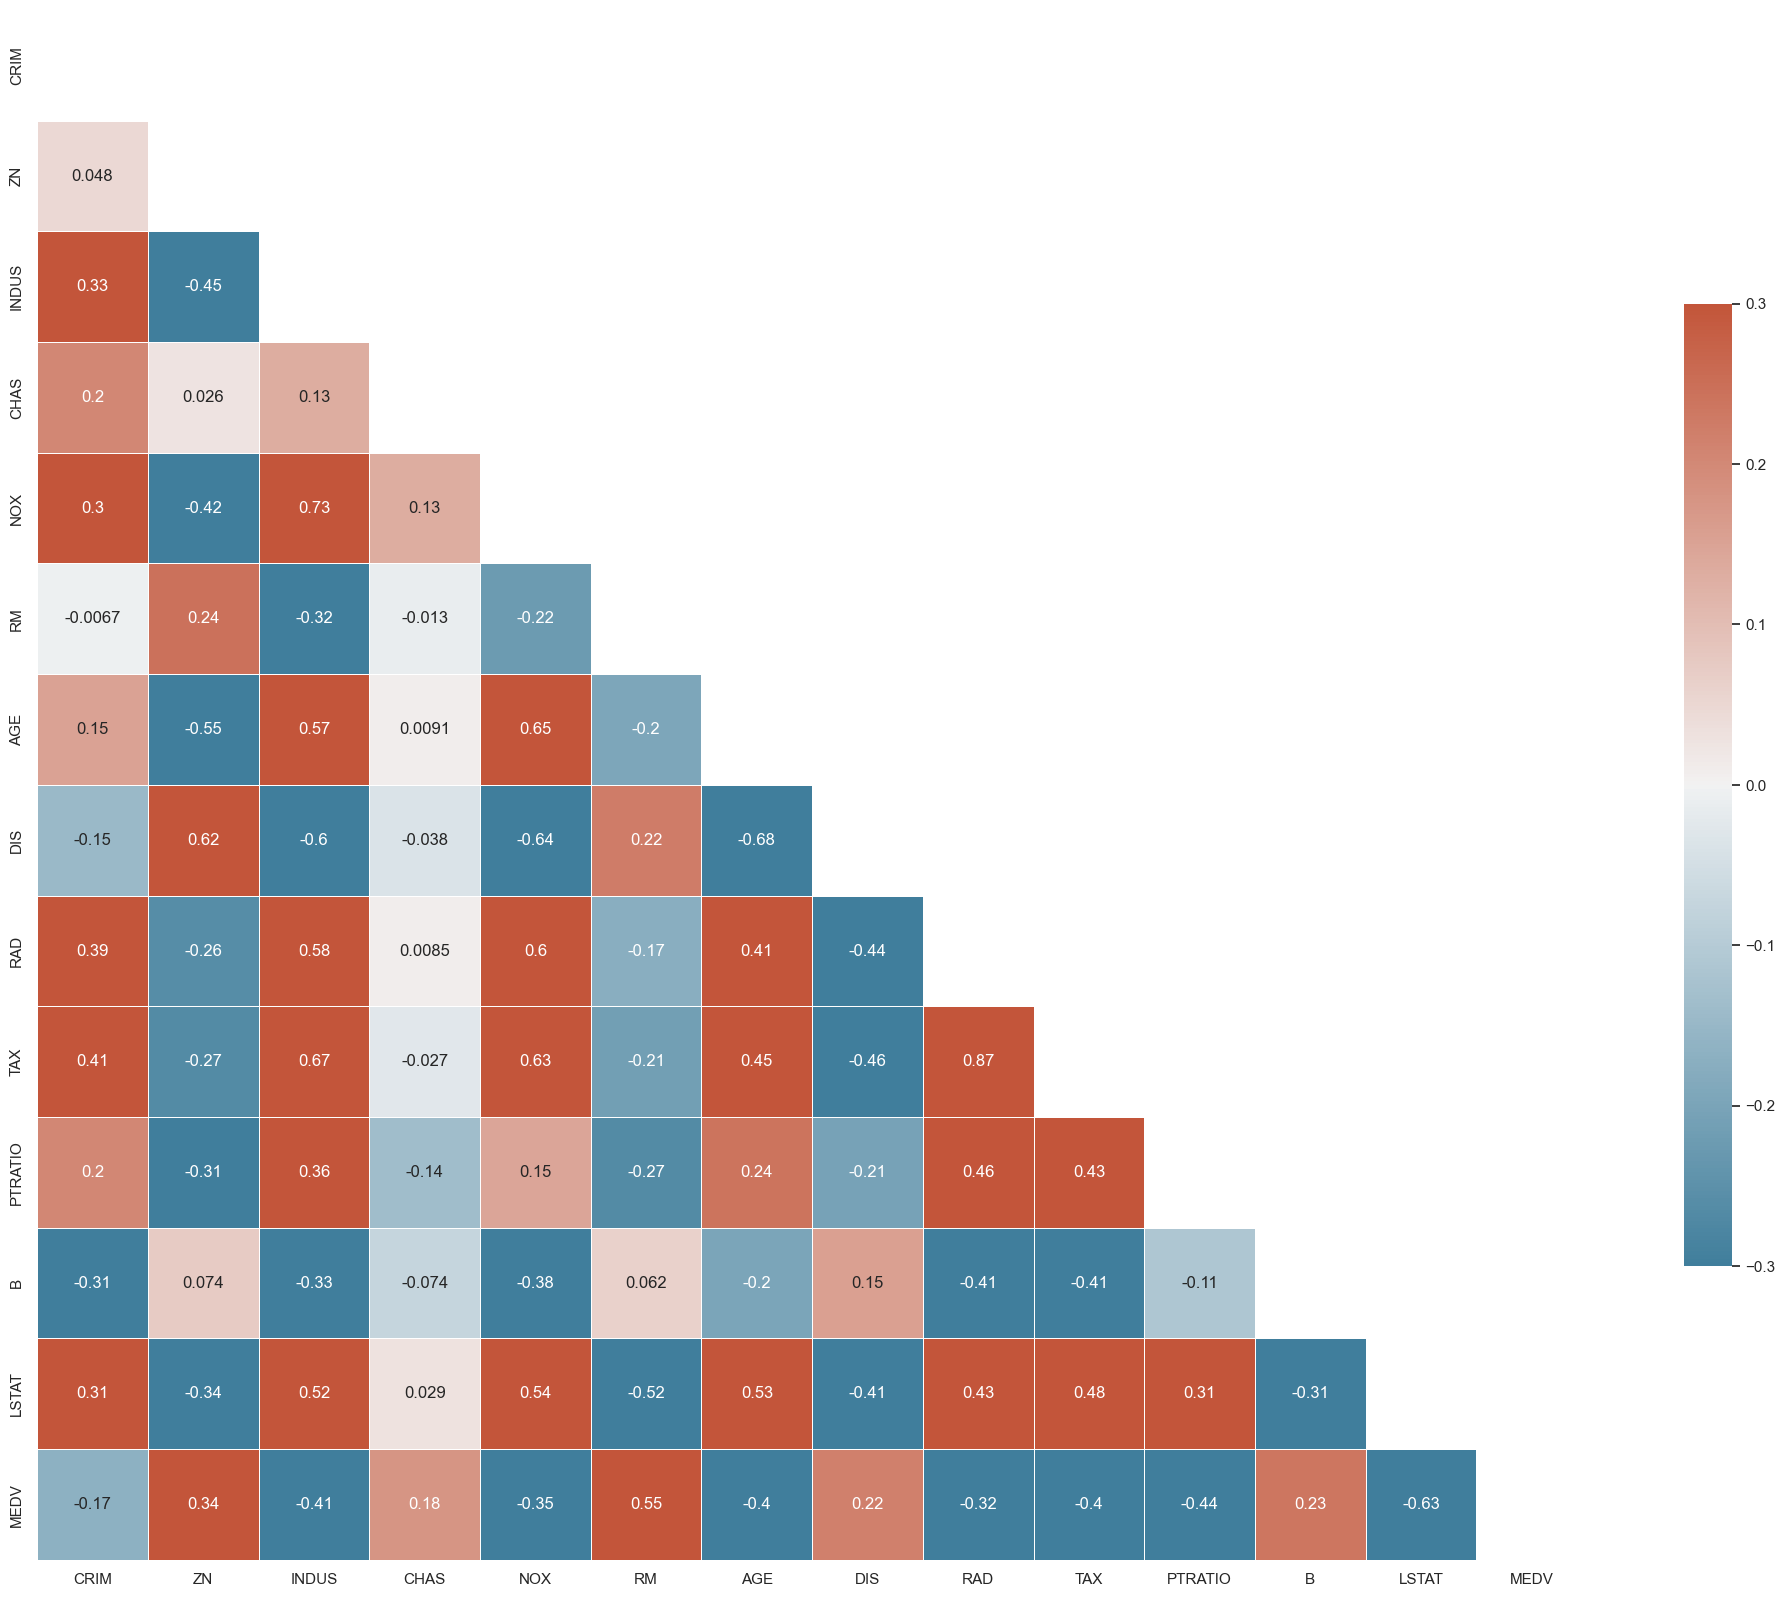

In [20]:
sns.set_theme(style="white")
# Creación de la matriz de correlación
corr = train[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


### **Relación de las variables con el precio de la vivienda (MEDV)**

- LSTAT (Porcentaje de población de estatus bajo): Correlación negativa fuerte (-0.63) con el precio de la vivienda (MEDV). Esto indica que, a medida que aumenta el porcentaje de personas de estatus bajo en una zona, el valor de las viviendas tiende a disminuir.
- RM (Número medio de habitaciones por vivienda): Correlación positiva significativa (0.55). A mayor número de habitaciones promedio, mayor es el precio de las viviendas, lo que tiene sentido ya que las casas más grandes suelen ser más caras.
- PTRATIO (Relación estudiante-profesor por zona): Correlación negativa moderada (-0.44). Un mayor PTRATIO (más estudiantes por maestro) parece estar asociado con precios de vivienda más bajos, lo que puede reflejar la calidad educativa de la zona.
- NOX (Concentración de óxidos nítricos): Correlación negativa moderada (-0.31). A mayor contaminación por NOX, los precios de las viviendas tienden a ser menores, lo cual es esperado en áreas con peor calidad ambiental.

### **Correlación entre las variables**
- TAX y RAD: Alta correlación positiva (0.87). Esto podría indicar que los distritos con mayor acceso a autopistas (RAD) tienden a tener impuestos más altos, lo que puede reflejar el desarrollo urbano en esas áreas.
- NOX y INDUS: Alta correlación positiva (0.73). Esto tiene sentido porque las áreas más industrializadas (INDUS) suelen tener niveles más altos de contaminación (NOX).
- DIS y INDUS: Correlación negativa significativa (-0.68). La distancia a centros de empleo (DIS) está negativamente correlacionada con la proporción de terrenos industriales, lo que sugiere que las zonas más alejadas de los centros urbanos tienen menos áreas industriales.

### **Otras observaciones importantes**

- CRIM (Índice de criminalidad per cápita) no muestra una correlación particularmente fuerte con el precio de la vivienda (-0.31), aunque hay una leve tendencia a que, a mayor criminalidad, los precios tiendan a bajar.
- AGE (Proporción de unidades construidas antes de 1940): Tiene una relación negativa moderada con el precio de la vivienda (-0.32), lo que puede reflejar que las casas más antiguas suelen tener un valor menor.

# División del conjunto de datos de entrenamiento y estandarizacion


In [82]:
from sklearn.preprocessing import StandardScaler

# Definir características (X) y variable objetivo (y)
X_train = train[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y_train = train['MEDV']

X_test = test[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y_test = test['MEDV']

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Usa el mismo escalador


**En el conjunto de entrenamiento:**
Se aplica fit_transform del StandardScaler para ajustar el escalador a los datos de entrenamiento y transformar esos datos.

**En el conjunto de prueba:**
Se aplica transform del StandardScaler ya ajustado para transformar los datos de prueba usando la misma media y desviación estándar que en el conjunto de entrenamiento.

Esto asegura una transformación consistente y evita la fuga de información.



# Regresión Lineal

La regresión lineal modela una relación lineal entre la variable dependiente y las variables independientes.

In [83]:
# Crea una instancia del modelo de regresión lineal
model_rl = LinearRegression()
model_rl.fit(X_train_scaled, y_train)

LinearRegression()

In [84]:
y_train_pred = model_rl.predict(X_train_scaled)
y_pred = model_rl.predict(X_test)

c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


#### Coeficiente e Intercepción

In [85]:
coefficients = model_rl.coef_
intercept = model_rl.intercept_
print("Coefficients:", coefficients)
print(f"\nIntercept:", intercept)

Coefficients: [-0.39210817  1.32026361 -0.16527452  1.57033697 -0.79706811  2.84459807
 -1.55521817 -2.71507458  1.62059968 -1.57769858 -1.7189919   0.57631171
 -2.75900253]

Intercept: 22.735516620311365


#### Métricas del set de entrenamiento

In [86]:
# MSE: Error Cuadratico Medio
mse_train = mean_squared_error(y_train, y_train_pred)

# R^2
r2_train = r2_score(y_train, y_train_pred)

# MAE: Error Absoluto Medio
mae_train = mean_absolute_error(y_train, y_train_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"\nR²: {r2_train}\n")
print(f"MSE(Error Cuadratico Medio): {mse_train}\n")
print(f"MAE(Error Absoluto Medio): {mae_train}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_train}\n")


R²: 0.5986287582542205

MSE(Error Cuadratico Medio): 33.686971703850446

MAE(Error Absoluto Medio): 3.8433429901522422

RMSE(Raíz del Error Cuadrático Medio): 5.80404787229141



#### Métricas del set de testeo

In [87]:
# MSE: Error Cuadratico Medio
mse = mean_squared_error(y_test, y_pred)

# R^2
r2 = r2_score(y_test, y_pred)

# MAE: Error Absoluto Medio
mae = mean_absolute_error(y_test, y_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nR²: {r2}\n")
print(f"MSE(Error Cuadratico Medio): {mse}\n")
print(f"MAE(Error Absoluto Medio): {mae}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse}\n")


R²: -4888.185746384238

MSE(Error Cuadratico Medio): 477543.851228188

MAE(Error Absoluto Medio): 603.7506387172172

RMSE(Raíz del Error Cuadrático Medio): 691.0454769609509



# Gradiente descendiente

In [47]:
# Regresión lineal utilizando SGDRegressor
# Instancia del modelo SGDRegressor
model_sgd = SGDRegressor(max_iter=1600, tol=1e-3, learning_rate='constant', eta0=0.01)
model_sgd.fit(X_train_scaled, y_train)

SGDRegressor(learning_rate='constant', max_iter=1600)

### sumar grafica


In [48]:
y_pred_sgd = model_sgd.predict(X_test_scaled)

In [49]:
y_train_pred_sgd = model_sgd.predict(X_train_scaled)

#### Coeficiente e Intercepción

In [50]:
coefficients_sgd = model_sgd.coef_
intercept_sgd = model_sgd.intercept_
print("Coefficients (SGD):", coefficients_sgd)
print(f"\nIntercept (SGD):", intercept_sgd)

Coefficients (SGD): [ 0.33325215  1.72553817 -0.1801075   1.00709335 -0.82851523  2.38189885
 -1.89680907 -2.49760801  1.26828735 -1.49305466 -2.07495338  0.4559842
 -2.39666605]

Intercept (SGD): [22.88011258]


#### Métricas del set de entrenamiento

In [51]:
# MSE: Error Cuadratico Medio
mse_train_sgd = mean_squared_error(y_train, y_train_pred_sgd)

# R^2
r2_train_sgd = r2_score(y_train, y_train_pred_sgd)

# MAE: Error Absoluto Medio
mae_train_sgd = mean_absolute_error(y_train, y_train_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_train_sgd = np.sqrt(mean_squared_error(y_train, y_train_pred_sgd))

print(f"\nR²: {r2_train_sgd}\n")
print(f"MSE(Error Cuadratico Medio): {mse_train_sgd}\n")
print(f"MAE(Error Absoluto Medio): {mae_train_sgd}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_train_sgd}\n")


R²: 0.5797706402833462

MSE(Error Cuadratico Medio): 35.269728066039164

MAE(Error Absoluto Medio): 3.9536776211342244

RMSE(Raíz del Error Cuadrático Medio): 5.938832213999581



#### Métricas del set de testeo

In [52]:
# MSE: Error Cuadrático Medio
mse_sgd = mean_squared_error(y_test, y_pred_sgd)

# R^2
r2_sgd = r2_score(y_test, y_pred_sgd)

# MAE: Error Absoluto Medio
mae_sgd = mean_absolute_error(y_test, y_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_sgd = np.sqrt(mse_sgd)

print(f"\nR² (SGD): {r2_sgd}\n")
print(f"MSE (SGD): {mse_sgd}\n")
print(f"MAE (SGD): {mae_sgd}\n")
print(f"RMSE (SGD): {rmse_sgd}\n")


R² (SGD): 0.6218417059006347

MSE (SGD): 36.93604160399195

MAE (SGD): 4.210369056800568

RMSE (SGD): 6.077502908595927



### Grafica

In [53]:

# Listas para almacenar el error en cada iteración
mse_train_list = []
mse_test_list = []

# Definimos las iteraciones
n_iteraciones = 1600

In [54]:
# Entrenamos el modelo manualmente para registrar el error en cada iteración
for i in range(1, n_iteraciones+1):
    model_sgd.partial_fit(X_train_scaled, y_train)
    
    # Predicciones para el conjunto de entrenamiento y prueba
    y_train_pred_sgd = model_sgd.predict(X_train_scaled)
    y_pred_sgd = model_sgd.predict(X_test_scaled)
    
    # Calculamos el error cuadrático medio (MSE) para ambos conjuntos
    mse_train_sgd = mean_squared_error(y_train, y_train_pred_sgd)
    mse_test_sgd = mean_squared_error(y_test, y_pred_sgd)
    
    # Guardamos el error en las listas
    mse_train_list.append(mse_train_sgd)
    mse_test_list.append(mse_test_sgd)


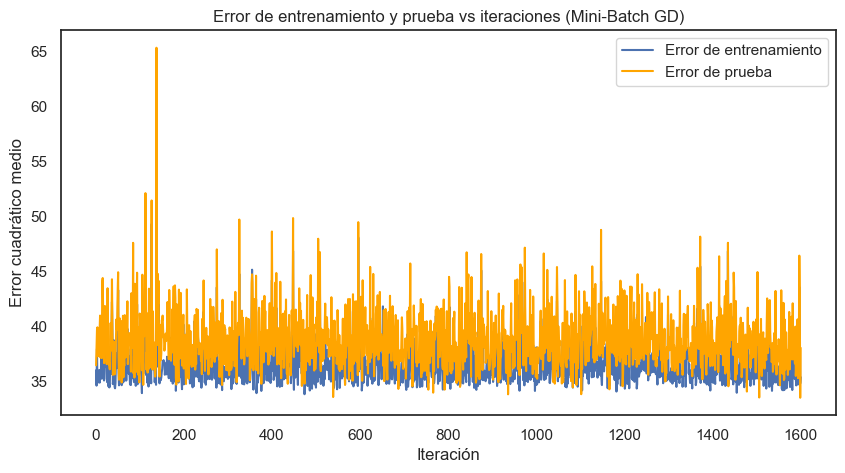

In [55]:
# Gráfica de Error (MSE) vs Iteraciones
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_iteraciones+1), mse_train_list, label='Error de entrenamiento')
plt.plot(range(1, n_iteraciones+1), mse_test_list, label='Error de prueba', color='orange')
plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
plt.xlabel('Iteración')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.show()

# Lasso, Ridge y Elastic Net

## Lasso

Penaliza la suma de los valores absolutos de los coeficientes, lo que puede llevar a algunos coeficientes a ser exactamente cero. Esto es útil para la selección de variables, ya que permite identificar las características más importantes.

In [88]:
lasso = Lasso(alpha=0.1) # alpha controla la fuerza de la regularización L1 (Lasso)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1)

In [89]:
print("Coeficientes del modelo Lasso:")
print(lasso.coef_)
print("\nCoeficientes del modelo Lasso de train:", lasso.score(X_train_scaled, y_train))
print("Coeficientes del modelo Lasso de test:", lasso.score(X_test_scaled, y_test))

Coeficientes del modelo Lasso:
[-0.23777612  1.0887694  -0.22382152  1.46880254 -0.49396629  2.7529645
 -1.40767427 -2.24439285  0.72827078 -0.88058602 -1.59275884  0.49834905
 -2.86045059]

Coeficientes del modelo Lasso de train: 0.5948927930056879
Coeficientes del modelo Lasso de test: 0.6417394464201766


In [90]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np

#'feature_names' es una lista con los nombres de las características
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# Primero, haz predicciones en los conjuntos de entrenamiento y prueba
y_pred_train_lasso = lasso.predict(X_train_scaled)
y_pred_test_lasso = lasso.predict(X_test_scaled)

# Error Cuadrático Medio (MSE)
mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train_lasso = sqrt(mse_train_lasso)
rmse_test_lasso = sqrt(mse_test_lasso)

# Error Absoluto Medio (MAE)
mae_train_lasso = mean_absolute_error(y_train, y_pred_train_lasso)
mae_test_lasso = mean_absolute_error(y_test, y_pred_test_lasso)

# Coeficiente de determinación (R²)
r2_train_lasso = r2_score(y_train, y_pred_train_lasso)
r2_test_lasso = r2_score(y_test, y_pred_test_lasso)

# Crear un DataFrame para las métricas del modelo
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Train': [mse_train_lasso, rmse_train_lasso, mae_train_lasso, r2_train_lasso],
    'Test': [mse_test_lasso, rmse_test_lasso, mae_test_lasso, r2_test_lasso]
})

# Imprimir el DataFrame de métricas
print("Métricas del modelo Lasso:")
print(metrics_df)

# Crear un DataFrame para los coeficientes del modelo
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso.coef_
})

# Filtrar los coeficientes no nulos
coefficients_df = coefficients_df[abs(coefficients_df['Coefficient']) > 1e-5]

# Agregar el término independiente al DataFrame
intercept_df = pd.DataFrame({
    'Feature': ['Intercept'],
    'Coefficient': [lasso.intercept_]
})

# Concatenar el término independiente con los coeficientes
coefficients_df = pd.concat([coefficients_df, intercept_df], ignore_index=True)

# Imprimir el DataFrame de coeficientes
print("\nCoeficientes del modelo Lasso:")
print(coefficients_df)

# Número de coeficientes no nulos
non_zero_coef = len(coefficients_df) - 1  # Restar 1 por el intercepto
print(f"\nNúmero de características seleccionadas: {non_zero_coef}")


Métricas del modelo Lasso:
  Metric      Train       Test
0    MSE  34.000530  34.992560
1   RMSE   5.830997   5.915451
2    MAE   3.850739   4.132986
3     R²   0.594893   0.641739

Coeficientes del modelo Lasso:
      Feature  Coefficient
0        CRIM    -0.237776
1          ZN     1.088769
2       INDUS    -0.223822
3        CHAS     1.468803
4         NOX    -0.493966
5          RM     2.752964
6         AGE    -1.407674
7         DIS    -2.244393
8         RAD     0.728271
9         TAX    -0.880586
10    PTRATIO    -1.592759
11          B     0.498349
12      LSTAT    -2.860451
13  Intercept    22.735517

Número de características seleccionadas: 13


## Ridge

In [91]:
ridge = Ridge(alpha=0.1) # alpha controla la fuerza de la regularización L2 (Ridge)
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=0.1)

In [92]:
print("Coeficientes del modelo Ridge:")
print(ridge.coef_)
print("\nCoeficientes del modelo Ridge de train:", ridge.score(X_train_scaled, y_train))
print("Coeficientes del modelo Ridge de test:", ridge.score(X_test_scaled, y_test))

Coeficientes del modelo Ridge:
[-0.39188074  1.31938085 -0.16617538  1.57016839 -0.79605432  2.84407115
 -1.55445866 -2.71298708  1.61751622 -1.57475336 -1.71857328  0.57630236
 -2.75886166]

Coeficientes del modelo Ridge de train: 0.598628701209777
Coeficientes del modelo Ridge de test: 0.6359322078318176


In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np

# Primero, haz predicciones en los conjuntos de entrenamiento y prueba
y_pred_train_ridge = ridge.predict(X_train_scaled)
y_pred_test_ridge = ridge.predict(X_test_scaled)

In [94]:
# Error Cuadrático Medio (MSE)
mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train_ridge = sqrt(mse_train_ridge)
rmse_test_ridge = sqrt(mse_test_ridge)

# Error Absoluto Medio (MAE)
mae_train_ridge = mean_absolute_error(y_train, y_pred_train_ridge)
mae_test_ridge = mean_absolute_error(y_test, y_pred_test_ridge)

# Coeficiente de determinación (R²)
r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

In [95]:
# Imprimir resultados
print("Métricas para el modelo Ridge:")
print("\nConjunto de entrenamiento:")
print(f"MSE: {mse_train_ridge:.4f}")
print(f"RMSE: {rmse_train_ridge:.4f}")
print(f"MAE: {mae_train_ridge:.4f}")
print(f"R²: {r2_train_ridge:.4f}")

print("\nConjunto de prueba:")
print(f"MSE: {mse_test_ridge:.4f}")
print(f"RMSE: {rmse_test_ridge:.4f}")
print(f"MAE: {mae_test_ridge:.4f}")
print(f"R²: {r2_test_ridge:.4f}")

Métricas para el modelo Ridge:

Conjunto de entrenamiento:
MSE: 33.6870
RMSE: 5.8040
MAE: 3.8432
R²: 0.5986

Conjunto de prueba:
MSE: 35.5598
RMSE: 5.9632
MAE: 4.1888
R²: 0.6359


In [96]:

# Coeficientes del modelo Ridge
print("\nCoeficientes del modelo Ridge:")

# Crear un DataFrame para los coeficientes
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge.coef_
})

# Filtrar coeficientes no nulos
coef_df = coef_df[np.abs(coef_df['Coefficient']) > 1e-5]

# Imprimir los coeficientes
print(coef_df)

# Intercept (término independiente)
print(f"\nIntercept: {ridge.intercept_:.4f}")

# Número de coeficientes no nulos
non_zero_coef = np.sum(np.abs(ridge.coef_) > 1e-5)
print(f"\nNúmero de características seleccionadas: {non_zero_coef}")


Coeficientes del modelo Ridge:
    Feature  Coefficient
0      CRIM    -0.391881
1        ZN     1.319381
2     INDUS    -0.166175
3      CHAS     1.570168
4       NOX    -0.796054
5        RM     2.844071
6       AGE    -1.554459
7       DIS    -2.712987
8       RAD     1.617516
9       TAX    -1.574753
10  PTRATIO    -1.718573
11        B     0.576302
12    LSTAT    -2.758862

Intercept: 22.7355

Número de características seleccionadas: 13


## Elastic Net

In [97]:
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticnet.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.1)

In [98]:
print("Coeficientes del modelo ElasticNet:")
print(elasticnet.coef_)
print("\nCoeficientes del modelo ElasticNet de train:", elasticnet.score(X_train_scaled, y_train))
print("Coeficientes del modelo ElasticNet de test:", elasticnet.score(X_test_scaled, y_test))

Coeficientes del modelo ElasticNet:
[-0.27987795  1.06637026 -0.29559425  1.46796207 -0.51771368  2.696837
 -1.33974911 -2.11391682  0.81397943 -0.90980204 -1.59631483  0.53407623
 -2.74092607]

Coeficientes del modelo ElasticNet de train: 0.5942852614706218
Coeficientes del modelo ElasticNet de test: 0.6409198703604546


In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Primero, haz predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = elasticnet.predict(X_train_scaled)
y_pred_test = elasticnet.predict(X_test_scaled)

# Error Cuadrático Medio (MSE)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train = sqrt(mse_train)
rmse_test = sqrt(mse_test)

# Error Absoluto Medio (MAE)
mae_train = mean_absolute_error(y_train, y_pred_train)  # Agregué y_pred_train aquí
mae_test = mean_absolute_error(y_test, y_pred_test)

# Coeficiente de determinación (R²)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Imprimir resultados
print("Métricas para el modelo ElasticNet:")
print("\nConjunto de entrenamiento:")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\nConjunto de prueba:")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"R²: {r2_test:.4f}")


Métricas para el modelo ElasticNet:

Conjunto de entrenamiento:
MSE: 34.0515
RMSE: 5.8354
MAE: 3.8502
R²: 0.5943

Conjunto de prueba:
MSE: 35.0726
RMSE: 5.9222
MAE: 4.1268
R²: 0.6409


In [100]:

# Coeficientes del modelo elasticnet
print("\nCoeficientes del modelo elasticnet:")

# Crear un DataFrame para los coeficientes
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': elasticnet.coef_
})

# Filtrar coeficientes no nulos
coef_df = coef_df[np.abs(coef_df['Coefficient']) > 1e-5]

# Imprimir los coeficientes
print(coef_df)

# Intercept (término independiente)
print(f"\nIntercept: {elasticnet.intercept_:.4f}")

# Número de coeficientes no nulos
non_zero_coef = np.sum(np.abs(elasticnet.coef_) > 1e-5)
print(f"\nNúmero de características seleccionadas: {non_zero_coef}")


Coeficientes del modelo elasticnet:
    Feature  Coefficient
0      CRIM    -0.279878
1        ZN     1.066370
2     INDUS    -0.295594
3      CHAS     1.467962
4       NOX    -0.517714
5        RM     2.696837
6       AGE    -1.339749
7       DIS    -2.113917
8       RAD     0.813979
9       TAX    -0.909802
10  PTRATIO    -1.596315
11        B     0.534076
12    LSTAT    -2.740926

Intercept: 22.7355

Número de características seleccionadas: 13


## Gráfico comparativo

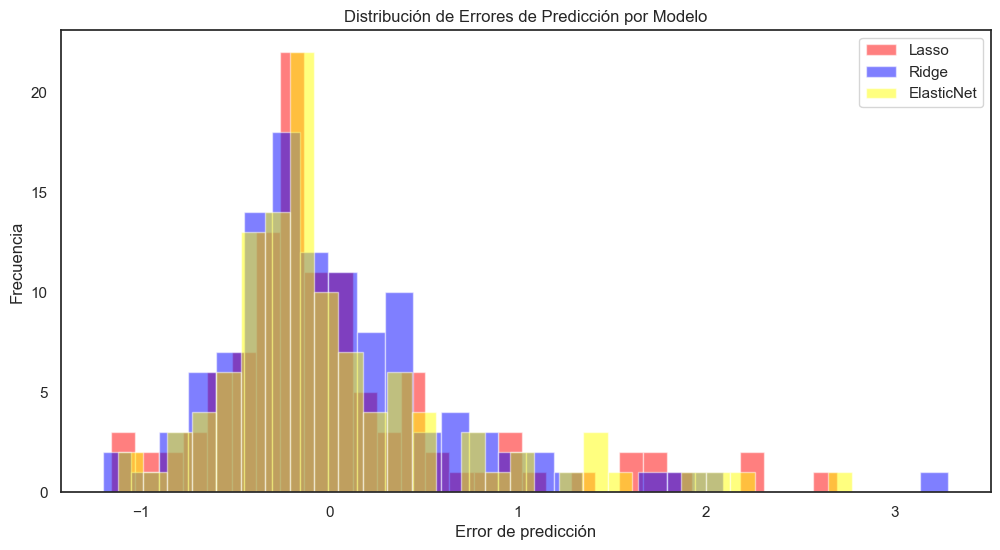

In [108]:
plt.figure(figsize=(12, 6))

plt.hist(y_test - lasso.predict(X_test_scaled), bins=30, alpha=0.5, label='Lasso', color='red')
plt.hist(y_test - ridge.predict(X_test_scaled), bins=30, alpha=0.5, label='Ridge', color='blue')
plt.hist(y_test - elasticnet.predict(X_test_scaled), bins=30, alpha=0.5, label='ElasticNet', color='yellow')

plt.xlabel('Error de predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores de Predicción por Modelo')
plt.legend()
plt.show()




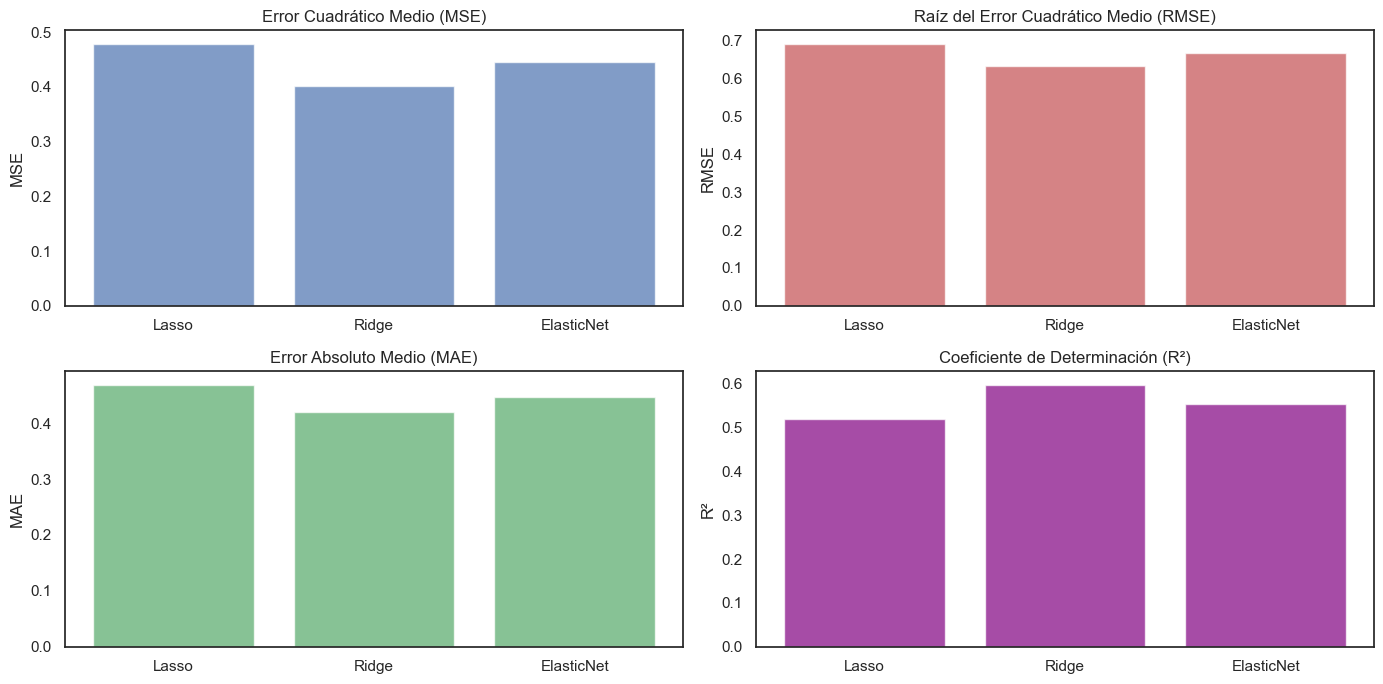

In [110]:
import matplotlib.pyplot as plt

# Supongamos que tienes los datos de métricas en listas
model_names = ['Lasso', 'Ridge', 'ElasticNet']
mse_values = [0.479362, 0.4014, 0.4457]
rmse_values = [ 0.692360, 0.6335, 0.6676]
mae_values = [0.469114, 0.4195, 0.4468]
r2_values = [0.520638, 0.5986, 0.5543]

x = range(len(model_names))

plt.figure(figsize=(14, 7))

# Gráfico de MSE
plt.subplot(2, 2, 1)
plt.bar(x, mse_values, color='b', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('MSE')
plt.title('Error Cuadrático Medio (MSE)')

# Gráfico de RMSE
plt.subplot(2, 2, 2)
plt.bar(x, rmse_values, color='r', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('RMSE')
plt.title('Raíz del Error Cuadrático Medio (RMSE)')

# Gráfico de MAE
plt.subplot(2, 2, 3)
plt.bar(x, mae_values, color='g', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('MAE')
plt.title('Error Absoluto Medio (MAE)')

# Gráfico de R²
plt.subplot(2, 2, 4)
plt.bar(x, r2_values, color='purple', alpha=0.7)
plt.xticks(x, model_names)
plt.ylabel('R²')
plt.title('Coeficiente de Determinación (R²)')

plt.tight_layout()
plt.show()


### Conclusiones generales:
- Ridge parece ser el modelo que mejor ajusta los datos en todas las métricas presentadas, con los menores valores de error y el mayor R².
- Lasso tiene un desempeño ligeramente peor en comparación con ElasticNet y Ridge, especialmente en el MSE y R².
- ElasticNet ofrece un desempeño intermedio, mostrando valores de error y ajuste cercanos a los de Ridge, pero sin superarlo en ninguna métrica.

Es esencial calcular las métricas en los conjuntos de **entrenamiento** y **prueba** para evaluar tanto cómo el modelo ha aprendido de los datos como su capacidad de generalizar a nuevos casos. Esto permite detectar **overfitting** o **underfitting**. Métricas como R², MSE, RMSE y MAE nos dan una visión clara del rendimiento y ajuste del modelo.

Ridge parece ofrecer el mejor fitting, con un balance adecuado entre precisión y generalización, mientras que ElasticNet también es una opción viable, pero Lasso muestra un ajuste más débil en comparación

# punto 5 seguir